![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [6]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [7]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('pred/test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033


### Exploración de datos

In [8]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [9]:
dataTraining.describe(include='object')

,State,Make,Model
count,400000,400000,400000
unique,51,38,525
top,TX,Ford,Silverado
freq,45918,62899,18085


In [10]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


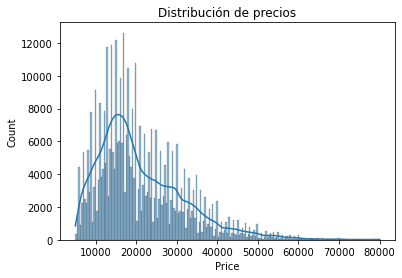

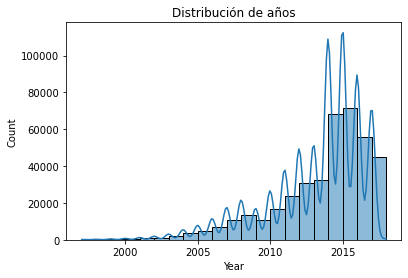

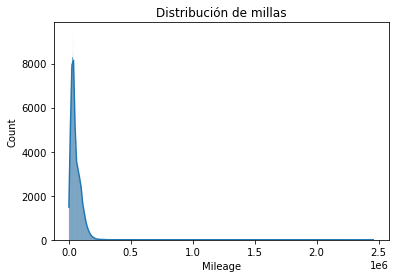

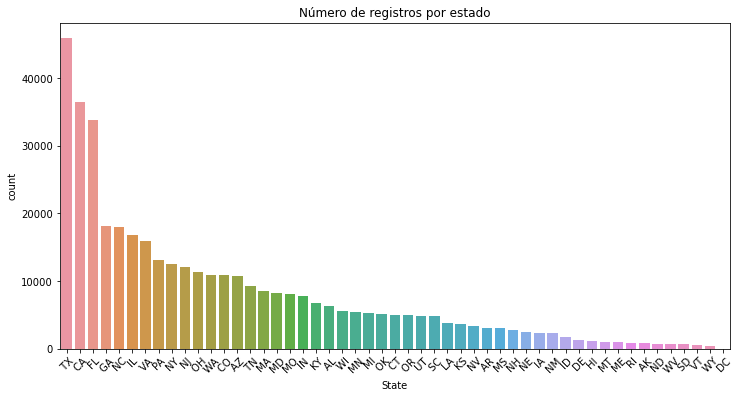

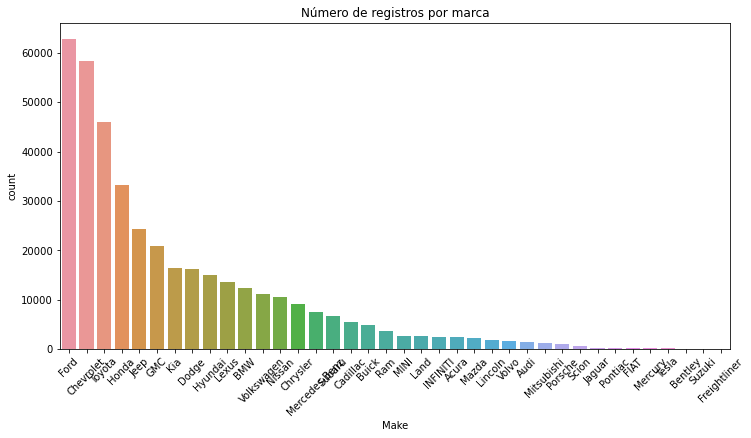

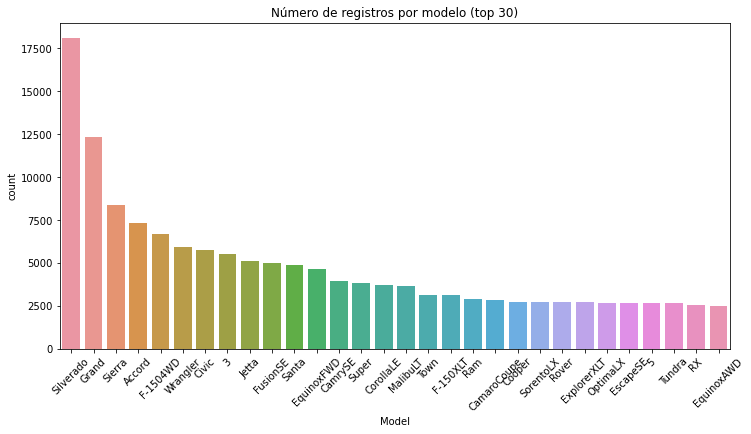

In [11]:
# Gráfica de distribución de precios
sns.histplot(dataTraining['Price'], kde=True)
plt.title('Distribución de precios')
plt.show()

# Gráfica de distribución de años
sns.histplot(dataTraining['Year'], kde=True, bins=range(dataTraining['Year'].min(), dataTraining['Year'].max() + 1))
plt.title('Distribución de años')
plt.show()

# Gráfica de distribución de millas
sns.histplot(dataTraining['Mileage'], kde=True)
plt.title('Distribución de millas')
plt.show()

# Gráfico de barras para la columna 'State'
plt.figure(figsize=(12, 6))
sns.countplot(data=dataTraining, x='State', order=dataTraining['State'].value_counts().index)
plt.title('Número de registros por estado')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para la columna 'Make'
plt.figure(figsize=(12, 6))
sns.countplot(data=dataTraining, x='Make', order=dataTraining['Make'].value_counts().index)
plt.title('Número de registros por marca')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para la columna 'Model'
plt.figure(figsize=(12, 6))
sns.countplot(data=dataTraining, x='Model', order=dataTraining['Model'].value_counts().iloc[:30].index)
plt.title('Número de registros por modelo (top 30)')
plt.xticks(rotation=45)
plt.show()

## 1. Preprocesamiento de datos (10 puntos)

* Los datos de entrenamiento se dividen en datos de entrenamiento y validación. Si decidieron preprocesar los datos (estandarizar, normalizar, imputar valores, etc), estos son correctamente preprocesados al ajustar sobre los datos de entrenamiento (.fit_transform()) y al transformar los datos del set de validación (.transform()). (10 puntos)

In [4]:
df = dataTraining.copy()
dfT = dataTesting.copy()

In [5]:
# Separación en datos de entrenamiento y valización 
X = df.drop("Price", axis=1)
y = df["Price"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Codificar las variables categóricas utilizando Target Encoding
encoder = TargetEncoder(cols=["State", "Make", "Model"])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)
dfT_encoded = encoder.transform(dfT)
X_train_encoded.head()

,Year,Mileage,State,Make,Model
242245,2014,40936,23283.783572,18017.040379,28539.053364
288918,2013,72553,20046.905799,22518.910885,14731.968389
105103,2016,102704,21320.457005,18017.040379,22105.431578
63504,2013,62279,20069.285509,36286.968693,36286.968693
239180,2012,37750,21059.873328,16240.885415,7781.692308


In [7]:
# Crear un pipeline de preprocesamiento para estandarizar los datos numéricos
numeric_features = ["Year", "Mileage"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='passthrough')

# Aplicar el preprocesamiento en los conjuntos de entrenamiento y validación
X_train_processed = preprocessor.fit_transform(X_train_encoded)
X_val_processed = preprocessor.transform(X_val_encoded)
dfT_processed = preprocessor.transform(dfT_encoded)

X_train_processed[:5]

array([[ 2.42664721e-01, -3.45436972e-01,  2.32837836e+04,
         1.80170404e+04,  2.85390534e+04],
       [-6.09840626e-02,  4.26373130e-01,  2.00469058e+04,
         2.25189109e+04,  1.47319684e+04],
       [ 8.49962288e-01,  1.16239636e+00,  2.13204570e+04,
         1.80170404e+04,  2.21054316e+04],
       [-6.09840626e-02,  1.75572074e-01,  2.00692855e+04,
         3.62869687e+04,  3.62869687e+04],
       [-3.64632846e-01, -4.23211175e-01,  2.10598733e+04,
         1.62408854e+04,  7.78169231e+03]])

## 2. Calibración del modelo (15 puntos)

### 2.1. Se calibran los parámetros que se consideren pertinentes del modelo de clasificación seleccionado. (5 puntos)



In [8]:
def save_pred(model, file_name, dfT_i):
    y_pred = pd.DataFrame(model.predict(dfT_i), index=dataTesting.index, columns=['Price'])
    y_pred.to_csv(f'pred/{ file_name }.csv', index_label='ID')

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, X_val, name, mape_only=False):
    mse = None
    r2 = None

    y_pred = model.predict(X_val)
    mape_m = mape(y_val, y_pred)
    
    if mape_only:
        mse = mean_squared_error(y_val, y_pred)
        r2 =  r2_score(y_val, y_pred)        

    measures_dic = {
        'Name': name,
        'MAPE': mape_m,
        'MSE': mse,        
        'R2': r2
    }

    return measures_dic

#### 2.1.1. Modelos a evaluar

In [45]:
# Crear y evaluar diferentes modelos de regresión
linear_regresion = LinearRegression()
elastic_net = ElasticNet(random_state=42)
random_forest = RandomForestRegressor(random_state=42)
xgboost = XGBRegressor(random_state=42)
lightgbm = LGBMRegressor(random_state=42)

linear_regresion.fit(X_train_processed, y_train)
elastic_net.fit(X_train_processed, y_train)
random_forest.fit(X_train_processed, y_train)
xgboost.fit(X_train_processed, y_train, eval_set=[(X_val_processed, y_val)], verbose=False)
lightgbm.fit(X_train_processed, y_train)

LGBMRegressor(random_state=42)

### 2.2. Se justifica el método seleccionado de calibración. (5 puntos)

In [72]:
models = [linear_regresion, elastic_net, random_forest, xgboost, lightgbm]
models_metrics = []
for m in models:
    name = m.__class__.__name__
    model_m = evaluate_model(m, X_val_processed, name)
    models_metrics.append(model_m)

pd.DataFrame(models_metrics).sort_values('MAPE')

,Name,MAPE,MSE,R2
2,RandomForestRegressor,11.901445,1.441879e+07,0.875373
3,XGBRegressor,13.087607,1.451549e+07,0.874537
4,LGBMRegressor,17.026311,2.078658e+07,0.820333
0,LinearRegression,38.053727,8.285155e+07,0.283882
1,ElasticNet,40.417445,8.717967e+07,0.246472


> Se selecciona RandomForestRegressor, XGBRegressor y LGBMRegressor para el siguiente etapa ya que sus métricas son significativamente mejores que las de LinearRegression y ElasticNet

#### 2.2.1. Staking y Voting

In [ ]:
# Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('random_forest', random_forest),
    ('xgboost', xgboost),
    ('lightgbm', lightgbm)
])
voting_regressor.fit(X_train_processed, y_train)



In [73]:
evaluate_model(voting_regressor, X_val_processed, 'Voting')

{'Name': 'Voting',
 'MAPE': 12.896743421817785,
 'MSE': 14164919.809560632,
 'R2': 0.8775670381913894}

In [ ]:
# Stacking Regressor
stacking_regressor1 = StackingRegressor(
    estimators=[
        ('linear_regresion', linear_regresion),
        ('elastic_net', elastic_net),
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('lightgbm', lightgbm)
    ],
    final_estimator=Ridge()
)
stacking_regressor1.fit(X_train_processed, y_train)



In [74]:
evaluate_model(stacking_regressor1, X_val_processed, 'Stacking')

{'Name': 'Stacking',
 'MAPE': 11.629656672191677,
 'MSE': 12999140.588607851,
 'R2': 0.8876433255798889}

In [64]:
save_pred(stacking_regressor1, 'staking_all models', dfT_processed)

In [76]:
# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('random_forest', random_forest),
        ('xgboost', xgboost),
        ('lightgbm', lightgbm)
    ],
    final_estimator=Ridge()
)
stacking_regressor.fit(X_train_processed, y_train)

evaluate_model(stacking_regressor, X_val_processed, 'Stacking')

{'Name': 'Stacking',
 'MAPE': 11.609277333070857,
 'MSE': 13003220.351046275,
 'R2': 0.8876080625917798}

In [57]:
save_pred(stacking_regressor, 'xgb_staking', dfT_processed)

evaluar xgboost

In [ ]:
xgboost2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
xgboost2.fit(X_train_processed, y_train,
          early_stopping_rounds=10,
          eval_set=[(X_val_processed, y_val)],
          verbose=False)



In [75]:
evaluate_model(xgboost2, X_val_processed, 'Xgboost')

{'Name': 'Xgboost',
 'MAPE': 11.7964169279784,
 'MSE': 12917228.133612018,
 'R2': 0.8883513270800023}

In [61]:
save_pred(xgboost2, 'xgb_TargetEncoder', dfT_processed)

### 2.3 Se analizan los valores calibrados de cada parámetro y se explica cómo afectan el modelo. (5 puntos)

Se hace la calibración von rl 20% de los datos de entrenamiento

In [10]:
_x, x_cal, _y, y_cal = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=42)

In [18]:
def plot_mape(ranges, mapes, xtitle):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=ranges, y=mapes)
    plt.xlabel(xtitle)
    plt.ylabel('MAPE')
    plt.show()

def comparate_model_param(model_fn, param, values, X=x_cal, y=y_cal, use_eval_set=False):
    mapes = []

    for val in values:
        model = model_fn(param, val)
        print(param, val)
        if (use_eval_set):
            model.fit(X, y)
        else:
            model.fit(X, y,
                eval_set=[(X_val_processed, y_val)],
                verbose=False)
        y_pred = model.predict(X_val_processed)
        
        mape_m = mape(y_val, y_pred)
        mapes.append(mape_m)

    display(pd.DataFrame({param: values, 'MAPE': mapes}).sort_values(by='MAPE').head(10))
    plot_mape(values, mapes, param)

#### 2.3.1. Calibración de RandomForestRegressor

##### 2.3.1.1 Max_depth

RandomForestRegressor(max_depth=10, random_state=42)
RandomForestRegressor(max_depth=20, random_state=42)
RandomForestRegressor(max_depth=30, random_state=42)
RandomForestRegressor(max_depth=40, random_state=42)
RandomForestRegressor(max_depth=50, random_state=42)
RandomForestRegressor(max_depth=60, random_state=42)
RandomForestRegressor(max_depth=70, random_state=42)
RandomForestRegressor(max_depth=80, random_state=42)
RandomForestRegressor(max_depth=90, random_state=42)


,max_depth,MAPE
4,50,13.100183
5,60,13.100183
6,70,13.100183
7,80,13.100183
8,90,13.100183
3,40,13.100600
2,30,13.101129
1,20,13.563531
0,10,22.300680


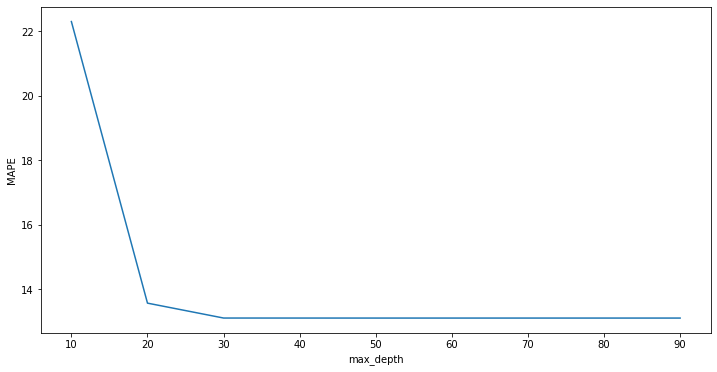

In [99]:
model_fn = lambda param, value: RandomForestRegressor(**{param: value}, random_state=42)
comparate_model_param(model_fn, 'max_depth', range(10, 100, 10))

RandomForestRegressor(max_depth=30, random_state=42)
RandomForestRegressor(max_depth=32, random_state=42)
RandomForestRegressor(max_depth=34, random_state=42)
RandomForestRegressor(max_depth=36, random_state=42)
RandomForestRegressor(max_depth=38, random_state=42)
RandomForestRegressor(max_depth=40, random_state=42)


,max_depth,MAPE
3,36,13.762850
2,34,13.763397
0,30,13.763906
4,38,13.765097
5,40,13.766099
1,32,13.766455


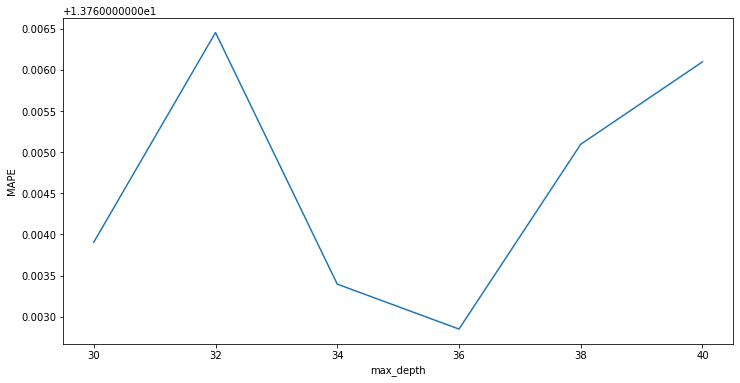

In [104]:
model_fn = lambda param, value: RandomForestRegressor(**{param: value}, random_state=42)
comparate_model_param(model_fn, 'max_depth', range(30, 42, 2))

> Se escoge a max_depth igual a 36

##### 2.3.1.2 max_features

RandomForestRegressor(max_depth=36, max_features=1, random_state=42)
RandomForestRegressor(max_depth=36, max_features=2, random_state=42)
RandomForestRegressor(max_depth=36, max_features=3, random_state=42)
RandomForestRegressor(max_depth=36, max_features=4, random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, random_state=42)


,max_features,MAPE
4,5,13.762850
3,4,14.005684
2,3,14.806034
1,2,16.374923
0,1,19.704498


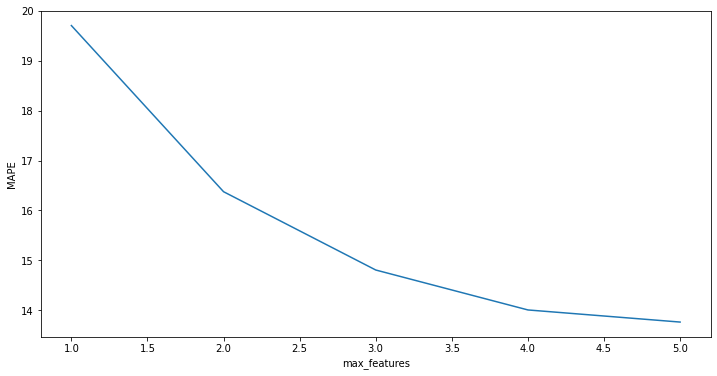

In [107]:
model_fn = lambda param, value: RandomForestRegressor(**{param: value}, max_depth=36, random_state=42)
comparate_model_param(model_fn, 'max_features', range(1, len(X.columns)+1))

> max_features igual a 5

##### 2.3.1.3 max_features

RandomForestRegressor(max_depth=36, max_features=5, n_estimators=50,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=150,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=200,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=250,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=300,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=350,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=400,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=450,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estima

,n_estimators,MAPE
9,500,13.673694
10,550,13.673881
8,450,13.674966
7,400,13.674975
6,350,13.678434
5,300,13.685721
4,250,13.689665
3,200,13.696293
2,150,13.711792
1,100,13.762850


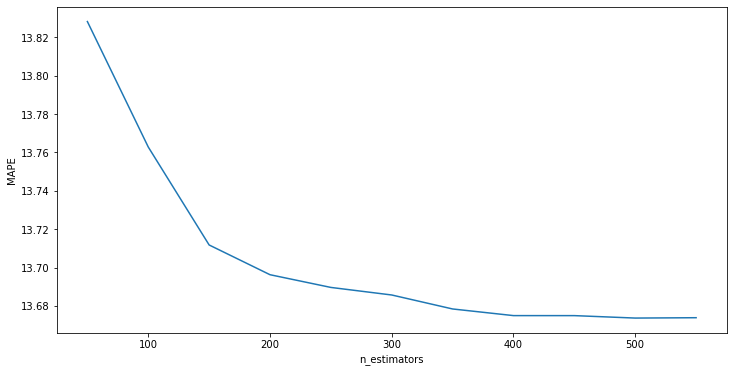

In [108]:
model_fn = lambda param, value: RandomForestRegressor(**{param: value}, max_features=5, max_depth=36, random_state=42)
comparate_model_param(model_fn, 'n_estimators', range(50, 600, 50))

RandomForestRegressor(max_depth=36, max_features=5, n_estimators=500,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=600,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=700,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=800,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=900,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1000,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1100,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1200,
                      random_state=42)


,n_estimators,MAPE
7,1200,13.662220
6,1100,13.666863
5,1000,13.669314
4,900,13.669347
2,700,13.670066
3,800,13.670154
1,600,13.670546
0,500,13.673694


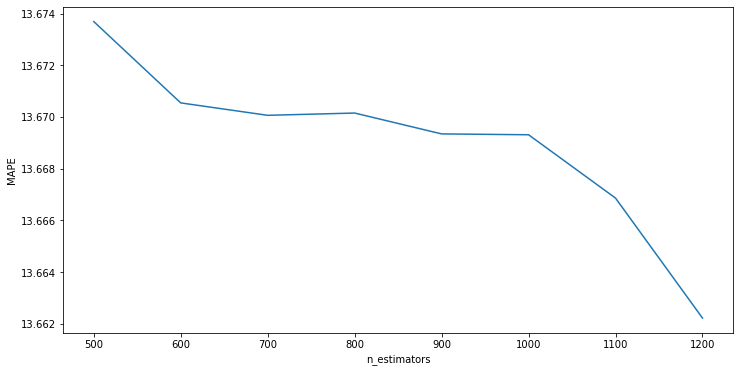

In [110]:
model_fn = lambda param, value: RandomForestRegressor(**{param: value}, max_features=5, max_depth=36, random_state=42)
comparate_model_param(model_fn, 'n_estimators', range(500, 1300, 100))

RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1200,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1300,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1400,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1500,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1600,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1700,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1800,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=1900,
                      random_state=42)
RandomForestRegressor(max_depth=36, max_features=5, n_estimators=2000,
                      random_state=42)


,n_estimators,MAPE
6,1800,13.658731
8,2000,13.658905
7,1900,13.658981
5,1700,13.659248
4,1600,13.660097
2,1400,13.660178
1,1300,13.660774
3,1500,13.661688
0,1200,13.662220


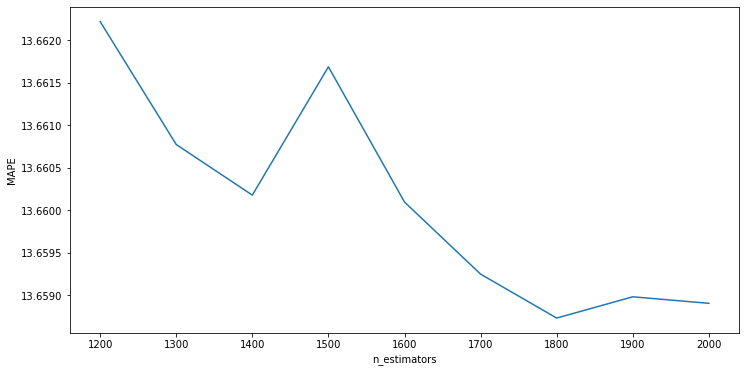

In [111]:
model_fn = lambda param, value: RandomForestRegressor(**{param: value}, max_features=5, max_depth=36, random_state=42)
comparate_model_param(model_fn, 'n_estimators', range(1200, 2100, 100))

> max_features igual a 200 y 1800

In [115]:
final_rf_model1 = RandomForestRegressor(n_estimators=200, max_features=5, max_depth=36, random_state=42)
final_rf_model1.fit(X_train_processed, y_train)
evaluate_model(final_rf_model1, X_val_processed, 'final rf model')

{'Name': 'final rf model',
 'MAPE': 11.878313814428635,
 'MSE': 14338964.601927564,
 'R2': 0.8760627007363714}

In [113]:
final_rf_model = RandomForestRegressor(n_estimators=1800, max_features=5, max_depth=36, random_state=42)
final_rf_model.fit(X_train_processed, y_train)
evaluate_model(final_rf_model, X_val_processed, 'final rf model')

{'Name': 'final rf model',
 'MAPE': 11.859626968619608,
 'MSE': 14290525.790919797,
 'R2': 0.8764813763927042}

In [114]:
save_pred(final_rf_model, 'final_rf_model', dfT_processed)

#### 2.3.2. Calibración de XGBRegressor


#### 2.3.2.1. max_depth

max_depth 2
max_depth 4
max_depth 6
max_depth 8
max_depth 10
max_depth 12
max_depth 14
max_depth 16
max_depth 18
max_depth 20


,max_depth,MAPE
3,8,11.690894
4,10,11.787050
5,12,11.976116
2,6,12.067622
6,14,12.282117
7,16,12.427785
8,18,12.643427
9,20,12.733041
1,4,13.131757
0,2,15.371382


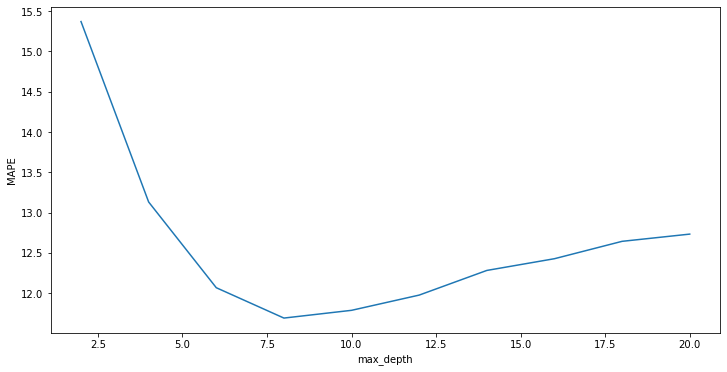

In [21]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
     random_state=42)
comparate_model_param(model_fn, 'max_depth', range(2, 22, 2), use_eval_set=True)
     

max_depth 6
max_depth 7
max_depth 8
max_depth 9
max_depth 10
max_depth 11
max_depth 12
max_depth 13
max_depth 14


,max_depth,MAPE
3,9,11.679899
2,8,11.690894
1,7,11.757338
4,10,11.787050
5,11,11.876747
6,12,11.976116
0,6,12.067622
7,13,12.125518
8,14,12.282117


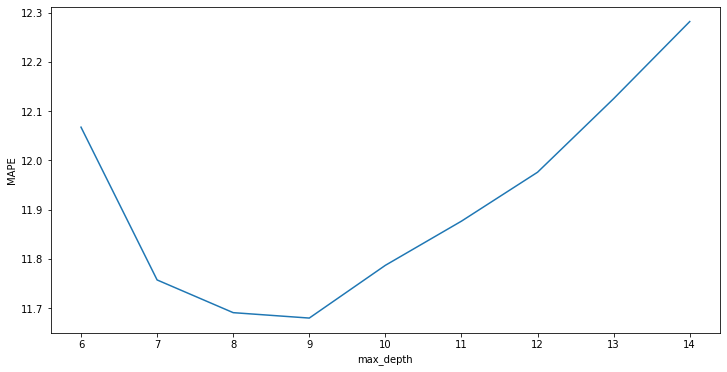

In [22]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
     random_state=42)
comparate_model_param(model_fn, 'max_depth', range(6, 15, 1), use_eval_set=True)
     

> max_depth igual a 9

##### 2.3.2.2 learning_rate

learning_rate 0.05
learning_rate 0.1
learning_rate 0.15000000000000002
learning_rate 0.2
learning_rate 0.25
learning_rate 0.3
learning_rate 0.35000000000000003
learning_rate 0.4
learning_rate 0.45
learning_rate 0.5


,learning_rate,MAPE
2,0.15,11.671188
4,0.25,11.675960
5,0.30,11.679899
3,0.20,11.725727
6,0.35,11.780014
1,0.10,11.823412
7,0.40,11.917892
8,0.45,12.029235
0,0.05,12.054017
9,0.50,12.185906


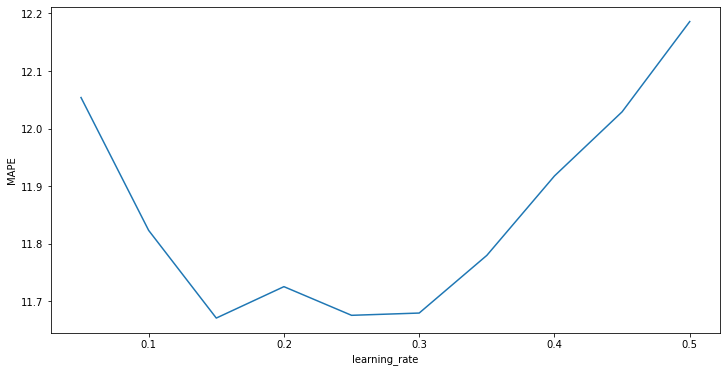

In [23]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
    max_depth = 9,
     random_state=42)
comparate_model_param(model_fn, 'learning_rate', np.arange(0.05, 0.55, 0.05), use_eval_set=True)
     

learning_rate 0.1
learning_rate 0.12000000000000001
learning_rate 0.14
learning_rate 0.16000000000000003
learning_rate 0.18000000000000002
learning_rate 0.2
learning_rate 0.22000000000000003
learning_rate 0.24000000000000002
learning_rate 0.26
learning_rate 0.28
learning_rate 0.30000000000000004
learning_rate 0.32000000000000006


,learning_rate,MAPE
6,0.22,11.646728
4,0.18,11.657675
7,0.24,11.665495
11,0.32,11.673632
10,0.30,11.679899
3,0.16,11.685373
8,0.26,11.685421
9,0.28,11.693771
1,0.12,11.706700
2,0.14,11.722502


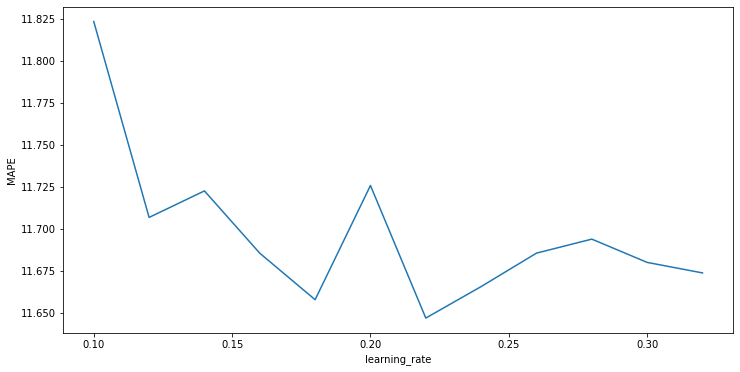

In [24]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
    max_depth = 9,
     random_state=42)
comparate_model_param(model_fn, 'learning_rate', np.arange(0.1, 0.34, 0.02), use_eval_set=True)
     

learning_rate 0.16
learning_rate 0.17
learning_rate 0.18000000000000002
learning_rate 0.19000000000000003
learning_rate 0.20000000000000004
learning_rate 0.21000000000000005
learning_rate 0.22000000000000006
learning_rate 0.23000000000000007


,learning_rate,MAPE
3,0.19,11.633448
6,0.22,11.646728
7,0.23,11.655190
2,0.18,11.657675
5,0.21,11.680090
1,0.17,11.681546
0,0.16,11.685373
4,0.20,11.725727


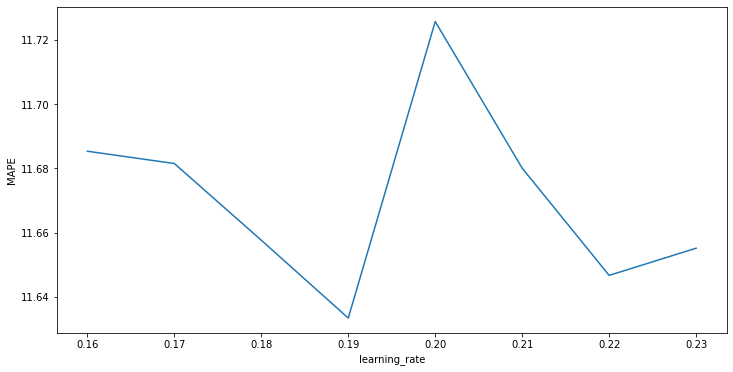

In [25]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
    max_depth = 9,
     random_state=42)
comparate_model_param(model_fn, 'learning_rate', np.arange(0.16, 0.24, 0.01), use_eval_set=True)
     

> learning_rate igual a 19

n_estimators 100
n_estimators 200
n_estimators 300
n_estimators 400
n_estimators 500
n_estimators 600
n_estimators 700
n_estimators 800
n_estimators 900
n_estimators 1000
n_estimators 1100


,n_estimators,MAPE
1,200,11.552265
2,300,11.582746
0,100,11.633448
3,400,11.642180
4,500,11.699793
5,600,11.771093
6,700,11.835687
7,800,11.885768
8,900,11.940300
9,1000,11.987864


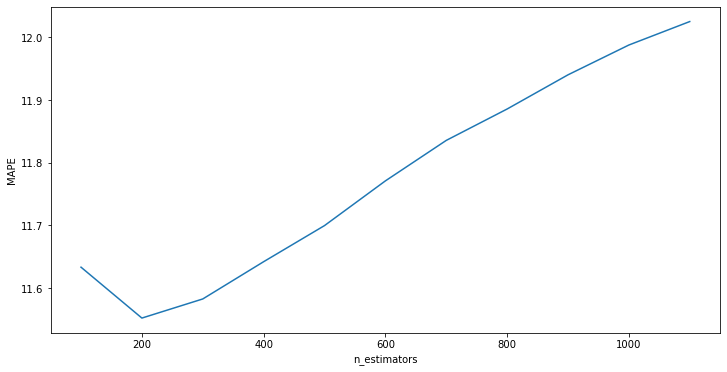

In [33]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
    learning_rate=0.19,
    max_depth=9,
     random_state=42)
comparate_model_param(model_fn, 'n_estimators', range(100, 1200, 100), use_eval_set=True)
     

n_estimators 100
n_estimators 120
n_estimators 140
n_estimators 160
n_estimators 180
n_estimators 200
n_estimators 220
n_estimators 240
n_estimators 260
n_estimators 280
n_estimators 300


,n_estimators,MAPE
6,220,11.547786
7,240,11.548971
5,200,11.552265
4,180,11.552333
9,280,11.565185
3,160,11.565209
2,140,11.565476
8,260,11.565763
1,120,11.582439
10,300,11.582746


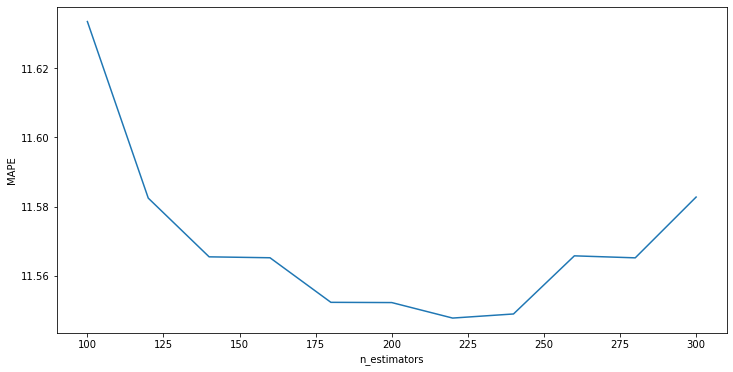

In [34]:
model_fn = lambda param, value: XGBRegressor(
    **{param: value},
    learning_rate=0.19,
    max_depth=9,
     random_state=42)
comparate_model_param(model_fn, 'n_estimators', range(100, 320, 20), use_eval_set=True)
     

> n_estimators igual a 220

In [36]:
final_xgb =  XGBRegressor(
    n_estimators=220,
    learning_rate=0.19,
    max_depth=9,
    random_state=42)

final_xgb.fit(X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    verbose=False)
evaluate_model(final_xgb, X_val_processed, 'final xgb model')

{'Name': 'final xgb model',
 'MAPE': 10.759654515009128,
 'MSE': None,
 'R2': None}

In [37]:
save_pred(final_xgb, 'final_xgb2', dfT_processed)

## 3. Disponibilización del modelo (30 puntos)

* Se disponibiliza el modelo en una API alojada en un servicio en la nube. (20 puntos)

* Se hacen las predicciones sobre el valor del automóvil en al menos dos observaciones del set de validación. (10 puntos)

## 4. Conclusiones (10 puntos)

* Se presentan conclusiones claras y concisas sobre el desarrollo y los resultados del proyecto. (10 puntos)